In [19]:
import pickle
import random
import ast
import warnings
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from itertools import combinations
from sklearn.metrics import make_scorer
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, RegressorMixin
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_fscore_support
from tqdm import tqdm
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 200)
from matplotlib import pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore")

## Load real dataset 

In [20]:
## load dataset
data = pd.read_pickle("train_encoded.pkl")
data_test = pd.read_pickle("test_encoded.pkl")

data["target"] = data["target"].astype(int)
data_test["target"] = data_test["target"].astype(int)

print(data.shape, data_test.shape)
data.head()

(2742, 107) (1176, 107)


,Баланс_endValue,Баланс_differnce,Баланс_attitude,Валовая прибыль (убыток)_startValue,Валовая прибыль (убыток)_endValue,Валовая прибыль (убыток)_differnce,Валовая прибыль (убыток)_attitude,Выручка_startValue,Выручка_endValue,Выручка_differnce,Выручка_attitude,Дебиторская задолженность_startValue,Дебиторская задолженность_endValue,Дебиторская задолженность_differnce,Дебиторская задолженность_attitude,Денежные средства и денежные эквиваленты_startValue,Денежные средства и денежные эквиваленты_endValue,Денежные средства и денежные эквиваленты_differnce,Денежные средства и денежные эквиваленты_attitude,Заемные средства_startValue,Заемные средства_endValue,Заемные средства_differnce,Заемные средства_attitude,Запасы_startValue,Запасы_endValue,Запасы_differnce,Запасы_attitude,Изменение отложенных налоговых активов_startValue,Изменение отложенных налоговых активов_differnce,Итого_startValue,Итого_endValue,Итого_differnce,Итого_attitude,Коммерческие расходы_startValue,Коммерческие расходы_endValue,Коммерческие расходы_differnce,Коммерческие расходы_attitude,Кредиторская задолженность_startValue,НДС по приобретенным ценностям_startValue,НДС по приобретенным ценностям_endValue,НДС по приобретенным ценностям_differnce,Нераспределенная прибыль (непокрытый убыток)_startValue,Нераспределенная прибыль (непокрытый убыток)_endValue,Нераспределенная прибыль (непокрытый убыток)_differnce,Нераспределенная прибыль (непокрытый убыток)_attitude,Основные средства_startValue,Основные средства_endValue,Основные средства_attitude,Отложенные налоговые активы_startValue,Отложенные налоговые активы_endValue,Отложенные налоговые активы_differnce,Отложенные налоговые обязательства_startValue,Отложенные налоговые обязательства_endValue,Оценочные обязательства_endValue,Постоянные налоговые обязательства (активы)_startValue,Постоянные налоговые обязательства (активы)_endValue,Постоянные налоговые обязательства (активы)_differnce,Прибыль (убыток) до налогообложения_startValue,Прибыль (убыток) до налогообложения_endValue,Прибыль (убыток) до налогообложения_differnce,Прибыль (убыток) до налогообложения_attitude,Прибыль (убыток) от продаж_startValue,Прибыль (убыток) от продаж_endValue,Прибыль (убыток) от продаж_differnce,Проценты к получению_startValue,Проценты к получению_endValue,Проценты к уплате_startValue,Проценты к уплате_endValue,Проценты к уплате_differnce,Проценты к уплате_attitude,Прочее_startValue,Прочее_differnce,Прочие внеоборотные активы_startValue,Прочие внеоборотные активы_endValue,Прочие доходы_startValue,Прочие доходы_endValue,Прочие доходы_differnce,Прочие доходы_attitude,Прочие оборотные активы_startValue,Прочие оборотные активы_endValue,Прочие оборотные активы_differnce,Прочие расходы_differnce,Прочие расходы_attitude,Себестоимость продаж_startValue,Себестоимость продаж_endValue,Себестоимость продаж_differnce,Себестоимость продаж_attitude,Совокупный финансовый результат периода_startValue,Совокупный финансовый результат периода_endValue,Совокупный финансовый результат периода_differnce,Совокупный финансовый результат периода_attitude,Текущий налог на прибыль_startValue,Текущий налог на прибыль_differnce,Текущий налог на прибыль_attitude,Управленческие расходы_startValue,Управленческие расходы_endValue,Управленческие расходы_differnce,Управленческие расходы_attitude,Уставный капитал_startValue,Уставный капитал_endValue,Финансовые вложения (за исключением денежных эквивалентов)_startValue,Финансовые вложения (за исключением денежных эквивалентов)_endValue,Финансовые вложения (за исключением денежных эквивалентов)_differnce,Чистая прибыль (убыток)_startValue,Чистая прибыль (убыток)_endValue,Чистая прибыль (убыток)_attitude,target
0,-1.442295,0.019913,-2.248771,0.840988,0.830437,0.842486,-0.290020,0.077531,-0.130108,0.085313,-1.086044,1.031331,1.008379,1.031331,0.156481,-0.159379,-0.972291,-0.292910,-1.240429,1.211534,1.219130,1.211534,0.321034,0.889849,0.315563,0.707528,-1.211389,1.399367,1.399367,0.156174,0.086889,-0.013382,0.808997,1.150686,1.127

In [21]:
target = 'target'

## Some help class and functions

In [22]:
def gini(y_true, y_pred):
    """ gini calcucate with roc_auc_score"""
    gini = 2 * roc_auc_score(y_true, y_pred) - 1
    return gini
    
gini_scorer = make_scorer(gini, greater_is_better=True)

In [23]:
def build_forward_logistic_regression_models(data, data_test, target, correlation_threshold = 0.7,
                                              p_value_threshold = 0.05, n_max_factors=None):
    """
    build forward logistic regression for choose final model
    - data: main dataframe with numeric factors and target column
    - data_test: test dataframe with numeric factors and target column
    - target: column name of target vaiables
    - n_max_factors: maximum number of factors in model
    """
    X_train = data.drop(target, axis=1)
    y_train = data[target]
    
    X_test = data_test.drop(target, axis=1)
    y_test = data_test[target]
    
    if n_max_factors == None:
        n_max_factors = X_train.shape[1]      
    modeling_result = []
    best_comb = []
    
    #Forward step
    for i in range(1, n_max_factors + 1): 
        print(f'Building {i}-factor models...')
        for factor in tqdm(X_train.columns):
            comb = best_comb+[factor]
            #Check correlations
            corrs = X_train[comb].corr()
            high_correlated_flag = (corrs.where(np.triu(np.ones(corrs.shape), k=1).astype(np.bool))>correlation_threshold).any().any()
            if high_correlated_flag:
                continue
                
            #Train/test
            log_reg = sm.Logit(y_train, sm.add_constant(X_train[comb])).fit(disp=0, method='bfgs')
            y_pred_train = log_reg.predict(sm.add_constant(X_train[comb]))
            y_pred_test = log_reg.predict(sm.add_constant(X_test[comb]))
            # Calc gini
            gini_train = gini(y_train, y_pred_train)
            gini_test = gini(y_test, y_pred_test)
            
            modeling_result.append({'cnt_factors': len(comb),
                                    'comb': comb,
                                    'gini_train': gini_train,
                                    'gini_test': gini_test,
                                    'gini_train_test_avg': (gini_train+gini_test)/2,
                                    })
            
        result_df = pd.DataFrame(modeling_result).sort_values('gini_train_test_avg', ascending=False)
        if result_df[result_df.cnt_factors==i].empty:
            print('Other factors are correlated')
            break
        else:
            best_comb = result_df[result_df.cnt_factors==i].reset_index(drop=True)['comb'][0]
        
           
        print(best_comb)
        print(result_df[result_df.cnt_factors==i].reset_index(drop=True)[['gini_train_test_avg','gini_train','gini_test']].iloc[0].values)
    return result_df

In [24]:
%%time
models = build_forward_logistic_regression_models(data,
                                                            data_test, 'target',
                                                            correlation_threshold = 0.7,
                                                            p_value_threshold = 0.05,
                                                            n_max_factors = 12)

Building 1-factor models...


100%|████████████████████████████████████████████████████████████████████████████████| 106/106 [00:01<00:00, 79.98it/s]


['Оценочные обязательства_endValue']
[0.59412669 0.61973104 0.56852235]
Building 2-factor models...


100%|████████████████████████████████████████████████████████████████████████████████| 106/106 [00:01<00:00, 78.05it/s]


['Оценочные обязательства_endValue', 'Чистая прибыль (убыток)_endValue']
[0.72749434 0.73981172 0.71517696]
Building 3-factor models...


100%|████████████████████████████████████████████████████████████████████████████████| 106/106 [00:02<00:00, 42.46it/s]


['Оценочные обязательства_endValue', 'Чистая прибыль (убыток)_endValue', 'Прибыль (убыток) от продаж_differnce']
[0.76304791 0.75982096 0.76627486]
Building 4-factor models...


100%|████████████████████████████████████████████████████████████████████████████████| 106/106 [00:02<00:00, 40.57it/s]


['Оценочные обязательства_endValue', 'Чистая прибыль (убыток)_endValue', 'Прибыль (убыток) от продаж_differnce', 'Нераспределенная прибыль (непокрытый убыток)_endValue']
[0.79978438 0.79715337 0.8024154 ]
Building 5-factor models...


100%|████████████████████████████████████████████████████████████████████████████████| 106/106 [00:02<00:00, 41.61it/s]


['Оценочные обязательства_endValue', 'Чистая прибыль (убыток)_endValue', 'Прибыль (убыток) от продаж_differnce', 'Нераспределенная прибыль (непокрытый убыток)_endValue', 'Проценты к уплате_startValue']
[0.81201381 0.81112399 0.81290364]
Building 6-factor models...


100%|████████████████████████████████████████████████████████████████████████████████| 106/106 [00:02<00:00, 43.03it/s]


['Оценочные обязательства_endValue', 'Чистая прибыль (убыток)_endValue', 'Прибыль (убыток) от продаж_differnce', 'Нераспределенная прибыль (непокрытый убыток)_endValue', 'Проценты к уплате_startValue', 'Баланс_attitude']
[0.82474106 0.8329231  0.81655903]
Building 7-factor models...


100%|████████████████████████████████████████████████████████████████████████████████| 106/106 [00:02<00:00, 39.23it/s]


['Оценочные обязательства_endValue', 'Чистая прибыль (убыток)_endValue', 'Прибыль (убыток) от продаж_differnce', 'Нераспределенная прибыль (непокрытый убыток)_endValue', 'Проценты к уплате_startValue', 'Баланс_attitude', 'Прочие расходы_differnce']
[0.83150219 0.83852751 0.82447688]
Building 8-factor models...


100%|████████████████████████████████████████████████████████████████████████████████| 106/106 [00:02<00:00, 38.41it/s]


['Оценочные обязательства_endValue', 'Чистая прибыль (убыток)_endValue', 'Прибыль (убыток) от продаж_differnce', 'Нераспределенная прибыль (непокрытый убыток)_endValue', 'Проценты к уплате_startValue', 'Баланс_attitude', 'Прочие расходы_differnce', 'Кредиторская задолженность_startValue']
[0.83487258 0.84092831 0.82881684]
Building 9-factor models...


100%|████████████████████████████████████████████████████████████████████████████████| 106/106 [00:02<00:00, 41.93it/s]


['Оценочные обязательства_endValue', 'Чистая прибыль (убыток)_endValue', 'Прибыль (убыток) от продаж_differnce', 'Нераспределенная прибыль (непокрытый убыток)_endValue', 'Проценты к уплате_startValue', 'Баланс_attitude', 'Прочие расходы_differnce', 'Кредиторская задолженность_startValue', 'Денежные средства и денежные эквиваленты_startValue']
[0.8396121  0.84765612 0.83156807]
Building 10-factor models...


100%|████████████████████████████████████████████████████████████████████████████████| 106/106 [00:02<00:00, 36.39it/s]


['Оценочные обязательства_endValue', 'Чистая прибыль (убыток)_endValue', 'Прибыль (убыток) от продаж_differnce', 'Нераспределенная прибыль (непокрытый убыток)_endValue', 'Проценты к уплате_startValue', 'Баланс_attitude', 'Прочие расходы_differnce', 'Кредиторская задолженность_startValue', 'Денежные средства и денежные эквиваленты_startValue', 'Нераспределенная прибыль (непокрытый убыток)_attitude']
[0.84518931 0.85476766 0.83561095]
Building 11-factor models...


100%|████████████████████████████████████████████████████████████████████████████████| 106/106 [00:03<00:00, 28.85it/s]


['Оценочные обязательства_endValue', 'Чистая прибыль (убыток)_endValue', 'Прибыль (убыток) от продаж_differnce', 'Нераспределенная прибыль (непокрытый убыток)_endValue', 'Проценты к уплате_startValue', 'Баланс_attitude', 'Прочие расходы_differnce', 'Кредиторская задолженность_startValue', 'Денежные средства и денежные эквиваленты_startValue', 'Нераспределенная прибыль (непокрытый убыток)_attitude', 'Прочие оборотные активы_endValue']
[0.84850157 0.85528266 0.84172049]
Building 12-factor models...


100%|████████████████████████████████████████████████████████████████████████████████| 106/106 [00:03<00:00, 30.96it/s]

['Оценочные обязательства_endValue', 'Чистая прибыль (убыток)_endValue', 'Прибыль (убыток) от продаж_differnce', 'Нераспределенная прибыль (непокрытый убыток)_endValue', 'Проценты к уплате_startValue', 'Баланс_attitude', 'Прочие расходы_differnce', 'Кредиторская задолженность_startValue', 'Денежные средства и денежные эквиваленты_startValue', 'Нераспределенная прибыль (непокрытый убыток)_attitude', 'Прочие оборотные активы_endValue', 'Финансовые вложения (за исключением денежных эквивалентов)_differnce']
[0.85168552 0.8592739  0.84409713]
Wall time: 30.9 s


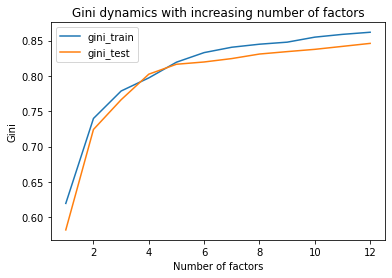

In [25]:
models.groupby('cnt_factors')['gini_train','gini_test'].max().plot();
plt.xlabel('Number of factors')
plt.ylabel('Gini')
plt.title('Gini dynamics with increasing number of factors');

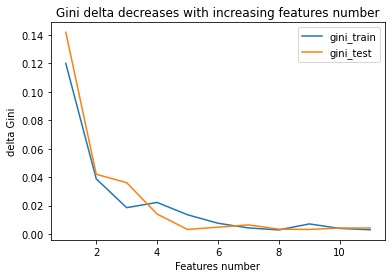

In [26]:
models.groupby('cnt_factors')['gini_train','gini_test'].max().reset_index().diff()[['gini_train','gini_test']].plot()
plt.xlabel('Features number')
plt.ylabel('delta Gini')
plt.title('Gini delta decreases with increasing features number')
plt.legend();

In [27]:
# Select combination with X features, becouse next feature gave to little impact for model
best_features_comb = models[models.cnt_factors == 7].sort_values('gini_train_test_avg', ascending=False).iloc[:1]['comb'].values[0]
best_features_comb

['Оценочные обязательства_endValue',
 'Чистая прибыль (убыток)_endValue',
 'Прибыль (убыток) от продаж_differnce',
 'Нераспределенная прибыль (непокрытый убыток)_endValue',
 'Проценты к уплате_startValue',
 'Баланс_attitude',
 'Прочие расходы_differnce']

In [28]:
X_train = data[best_features_comb]
y_train = data["target"]

X_test = data_test[best_features_comb]
y_test = data_test["target"]

x_train = sm.add_constant(X_train)
x_test = sm.add_constant(X_test)

log_reg = sm.Logit(y_train, x_train).fit(disp=0, method='bfgs') 
y_pred_train = log_reg.predict(x_train)
y_pred_test = log_reg.predict(x_test)

gini_train = gini(y_train, y_pred_train)
gini_test = gini(y_test, y_pred_test)

print('Train score: ', gini_train)
print('Test score:  ', gini_test)

Train score:  0.8385275057621864
Test score:   0.8244768793593387


In [29]:
log_reg.save('best_model.pkl')